Using the colorConv plugin to overcome problems with databroker not handling RGB images. 

In [114]:
#configure a temp run engine environment

from bluesky import RunEngine

RE = RunEngine({})

from bluesky.callbacks.best_effort import BestEffortCallback
bec = BestEffortCallback()

# Send all metadata/data captured to the BestEffortCallback.
RE.subscribe(bec)

#Get the databroker https://gist.github.com/untzag/53281819709b1058c7708a250cbd3676
from databroker.v2 import temp
db = temp()

# Insert all metadata/data captured into db.
RE.subscribe(db.v1.insert)


1

In [205]:
# create the SimDetector Device with a TIFF filesave mixin

# https://github.com/NSLS-II-OPLS/profile_collection/blob/6960f16e4b622e1cc2bf4703cfa07e3340a617f2/startup/45-pilatus.py#L53-L54

from ophyd import ( Component as Cpt, ADComponent, Device, PseudoPositioner,
                    EpicsSignal, EpicsSignalRO, EpicsMotor,
                    ROIPlugin, ImagePlugin,
                    SingleTrigger, PilatusDetector,
                    OverlayPlugin, FilePlugin, TIFFPlugin, SimDetector, TIFFPlugin, StatsPlugin, SimDetectorCam, ColorConvPlugin)
from ophyd.areadetector.filestore_mixins import FileStoreTIFFIterativeWrite
from ophyd import Component as Cpt

class SimDetectorCamV33(SimDetectorCam):
    '''This is used to update the SimDetectorCam to AD33.'''

    wait_for_plugins = Cpt(EpicsSignal, 'WaitForPlugins',
                           string=True, kind='config')

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.stage_sigs['wait_for_plugins'] = 'Yes'

    def ensure_nonblocking(self):
        self.stage_sigs['wait_for_plugins'] = 'Yes'
        for c in self.parent.component_names:
            cpt = getattr(self.parent, c)
            if cpt is self:
                continue
            if hasattr(cpt, 'ensure_nonblocking'):
                cpt.ensure_nonblocking()
    


class SimDetector(SimDetector):
    cam = Cpt(SimDetectorCamV33, 'cam1:')

class TIFFPluginWithFileStore(TIFFPlugin, FileStoreTIFFIterativeWrite):
    ...

class MySimDetector(SingleTrigger, SimDetector):
    tiff = Cpt(TIFFPluginWithFileStore,
               suffix="TIFF1:",
               write_path_template="/home/emil/Apps/autosave/images/")
    stats = Cpt(StatsPlugin, 'Stats1:')
    image = Cpt(ImagePlugin, 'image1:')
    colour = Cpt(ColorConvPlugin, 'CC1:')
    
    

def set_detector(det):

    det.tiff.kind = 'normal' 
    det.stats.kind = 'hinted'
    det.colour.kind = 'normal'
    det.image.kind = 'hinted'
    det.stats.total.kind = 'hinted'
    det.stats.centroid.x.kind = 'hinted' 
    det.stats.centroid.y.kind = 'hinted' 
    det.cam.ensure_nonblocking()
    det.tiff.nd_array_port.put(det.colour.port_name.get()) # makes the tiff plugin take the output of the colour change plugin


In [206]:
my_sim_cam = MySimDetector('SISSY1EX:Simdetector1:', name='test')
my_sim_cam.colour.color_mode.get()

0

In [207]:
my_sim_cam.wait_for_connection()

In [208]:
my_sim_cam.colour.port_name.get()

'CC1'

In [209]:
set_detector(my_sim_cam)

#initially configure as mono to show everything works
my_sim_cam.cam.color_mode.put('Mono')


In [210]:
import databroker.core
handler_registry = databroker.core.discover_handlers()
# make sure that the python package area-detector-handlers is installed!

In [211]:
from bluesky.plans import count
RE(count([my_sim_cam]))



Transient Scan ID: 5     Time: 2021-08-05 16:49:53
Persistent Unique Scan ID: '9e44acd2-4a39-4490-a4ac-590cbfa4d65c'
New stream: 'primary'
+-----------+------------+------------------+
|   seq_num |       time | test_stats_total |
+-----------+------------+------------------+
|         1 | 16:49:54.0 |         14619924 |
+-----------+------------+------------------+
generator count ['9e44acd2'] (scan num: 5)





('9e44acd2-4a39-4490-a4ac-590cbfa4d65c',)

In [212]:
run = db[-1]

#This has dimension 2 as we expect
run.primary.metadata['descriptors'][0]['data_keys']['test_image']['shape']

[1, 1024, 1024]

(1024, 1024)

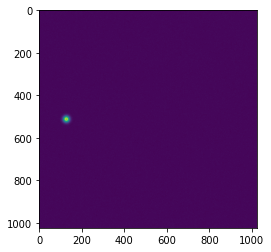

In [213]:
import glob
import os

list_of_files = glob.glob('/home/emil/Apps/autosave/images/*') # * means all if need specific format then *.csv
latest_file = max(list_of_files, key=os.path.getctime)

from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline
pil_im = Image.open(latest_file, 'r')
imshow(np.asarray(pil_im))

import numpy as np
imarray = np.array(pil_im)
imarray.shape

In [214]:
image = run.primary.read()["test_image"]


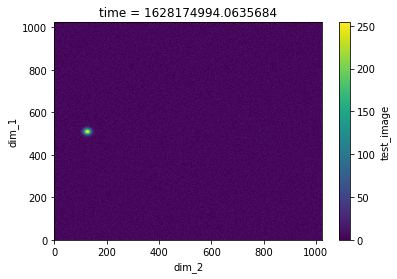

In [215]:

frame =image[0][0]
frame.plot.pcolormesh()
db_imarray = np.array(frame)

In [216]:
if db_imarray.all() == imarray.all():
    print('They are the same')

They are the same


In [217]:
#Now repeat it but setting colour mode to RGB1

#initiall configure as mono to show everything works
my_sim_cam.cam.color_mode.put('RGB1') #0 is mono, 1 is RGB1

In [218]:
from bluesky.plans import count
RE(count([my_sim_cam]))



Transient Scan ID: 6     Time: 2021-08-05 16:50:02
Persistent Unique Scan ID: '8a3b819c-03aa-4255-92e8-21e2b67cc5e3'
New stream: 'primary'
+-----------+------------+------------------+
|   seq_num |       time | test_stats_total |
+-----------+------------+------------------+
|         1 | 16:50:02.1 |          4875720 |
+-----------+------------+------------------+
generator count ['8a3b819c'] (scan num: 6)





('8a3b819c-03aa-4255-92e8-21e2b67cc5e3',)

(1024, 1024)

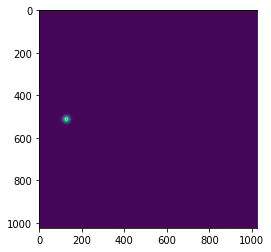

In [219]:
import glob
import os

list_of_files = glob.glob('/home/emil/Apps/autosave/images/*') # * means all if need specific format then *.csv
latest_file = max(list_of_files, key=os.path.getctime)

from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline
pil_im = Image.open(latest_file, 'r')
imshow(np.asarray(pil_im))

import numpy as np
imarray = np.array(pil_im)
imarray.shape

In [233]:
run = db[-1]
run.primary.metadata['descriptors'][0]['data_keys']['test_image']['shape']

[1, 1024, 1024]

In [234]:
#This is wrong, it should be 3, which is why we get the following error when we try to read

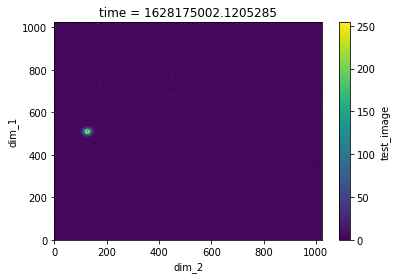

In [236]:
image = run.primary.read()["test_image"]
frame =image[0][0]
frame.plot.pcolormesh()
db_imarray = np.array(frame)

In [223]:
# The dimension of the image is wrong in the metadata. But it looks like it's correct in the ophyd device itself

In [224]:
my_sim_cam.image.ndimensions.get() # This is correct

3

In [225]:
my_sim_cam.tiff.ndimensions.get() # So is this

2

In [226]:
my_sim_cam.cam.array_size.get()

ArraySizeTuple(array_size_z=0, array_size_y=1024, array_size_x=1024)

In [227]:
my_sim_cam.describe()

OrderedDict([('test_image',
              {'shape': (1, 1024, 1024),
               'source': 'PV:SISSY1EX:Simdetector1:',
               'dtype': 'array',
               'external': 'FILESTORE:'}),
             ('test_stats_total',
              {'source': 'PV:SISSY1EX:Simdetector1:Stats1:Total_RBV',
               'dtype': 'number',
               'shape': [],
               'units': '',
               'lower_ctrl_limit': 0.0,
               'upper_ctrl_limit': 0.0,
               'precision': 0})])